In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [64]:
Dataset= "Data.csv"
df = pd.read_csv(Dataset)
print(df)

       Total Household Income              Region  Staple Food Expenditure  \
0                        9370                 CAR                     1736   
1                        3540                 CAR                      718   
2                        1478                 CAR                     1281   
3                        2199                 CAR                     1273   
4                        4732                 CAR                     1386   
...                       ...                 ...                      ...   
41539                    3820  XII - SOCCSKSARGEN                      906   
41540                    3850  XII - SOCCSKSARGEN                      159   
41541                    4138  XII - SOCCSKSARGEN                     1076   
41542                    4231  XII - SOCCSKSARGEN                     1206   
41543                    4181  XII - SOCCSKSARGEN                     1676   

                 Source of Income  Agricultural Household indic

#### DataCleaning - Removing rows that total income + entrepreneurial income < total expenses

In [65]:
df_cleaned = df.copy()

expense_columns = [
    "Staple Food Expenditure", "Meat Expenditure", "Seafood Expenditure", "Leisure Expenditure",
    "Alcohol Expenditure", "Tobacco Expenditure", "Medical Expenditure", "Transportation Expenditure",
    "Communication Expenditure", "Utilities Expenditure", "Housing Tax", "Education Expenditure",
    "Crop Farming Expenditure"
]
available_expense_columns = [col for col in expense_columns if col in df_cleaned.columns]
if not available_expense_columns:
    raise ValueError("None of the specified expense columns are available in the dataset.")

df_cleaned["Total Expenses"] = df_cleaned[available_expense_columns].sum(axis=1)

if "Entrepreneurial Income" in df_cleaned.columns:
    df_cleaned = df_cleaned[
        (df_cleaned["Total Household Income"] + df_cleaned["Entrepreneurial Income"]) >= df_cleaned["Total Expenses"]
    ]
else:
    df_cleaned = df_cleaned[df_cleaned["Total Household Income"] >= df_cleaned["Total Expenses"]]


#### Income Brackets

In [66]:
income_quantiles = df_cleaned["Total Household Income"].quantile([0.33, 0.66, 1.0])
low_income_threshold = income_quantiles[0.33]
medium_income_threshold = income_quantiles[0.66]

def categorize_income(income):
    if income <= low_income_threshold:
        return "Low"
    elif income <= medium_income_threshold:
        return "Medium"
    else:
        return "High"

df_cleaned["Income Level"] = df_cleaned["Total Household Income"].apply(categorize_income)


#### Avg Expenditure by Category by Income Group

In [67]:
available_expenditure_columns = [col for col in expense_columns if col in df_cleaned.columns]
expenditure_summary = df_cleaned.groupby("Income Level")[available_expenditure_columns].mean().reset_index()


#### Visualizing Income vs Expenditure trends

<Figure size 1200x600 with 0 Axes>

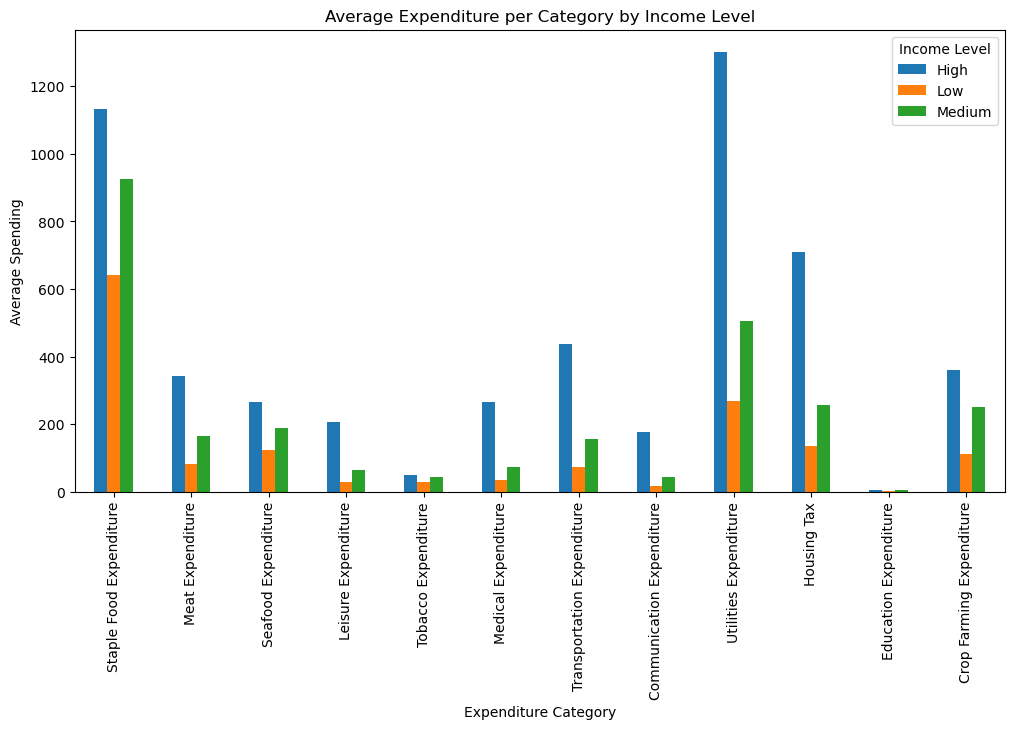

In [68]:
plt.figure(figsize=(12, 6))
expenditure_summary.set_index("Income Level").T.plot(kind="bar", figsize=(12, 6))
plt.xlabel("Expenditure Category")
plt.ylabel("Average Spending")
plt.title("Average Expenditure per Category by Income Level")
plt.legend(title="Income Level")
plt.xticks(rotation=90)
plt.show()

#### Boxplot for Spending Patterns

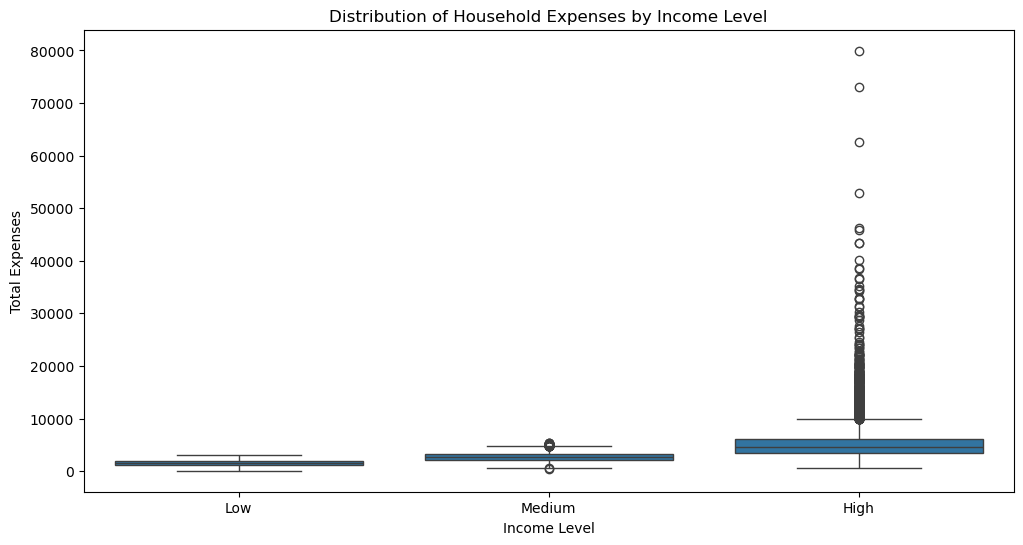

In [69]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Income Level", y="Total Expenses", data=df_cleaned, order=["Low", "Medium", "High"])
plt.xlabel("Income Level")
plt.ylabel("Total Expenses")
plt.title("Distribution of Household Expenses by Income Level")
plt.show()

#### Pie Chart for Proportion of Spending Categories of Each Income Level

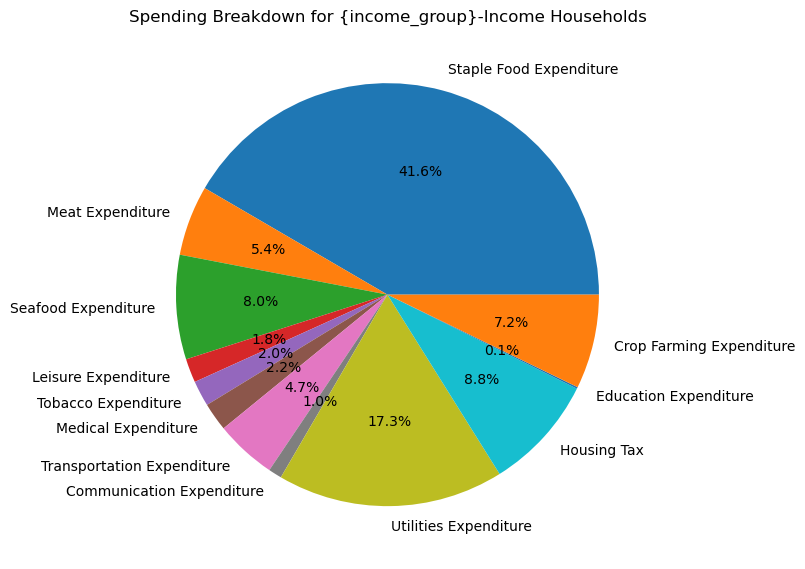

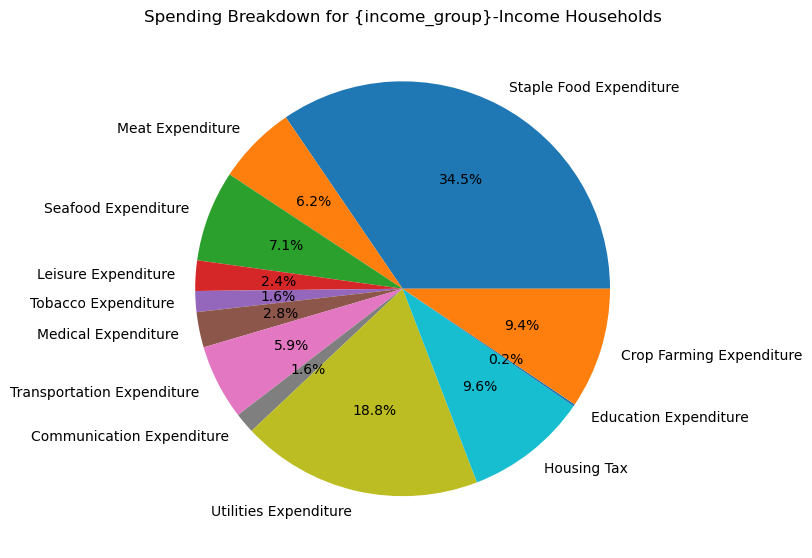

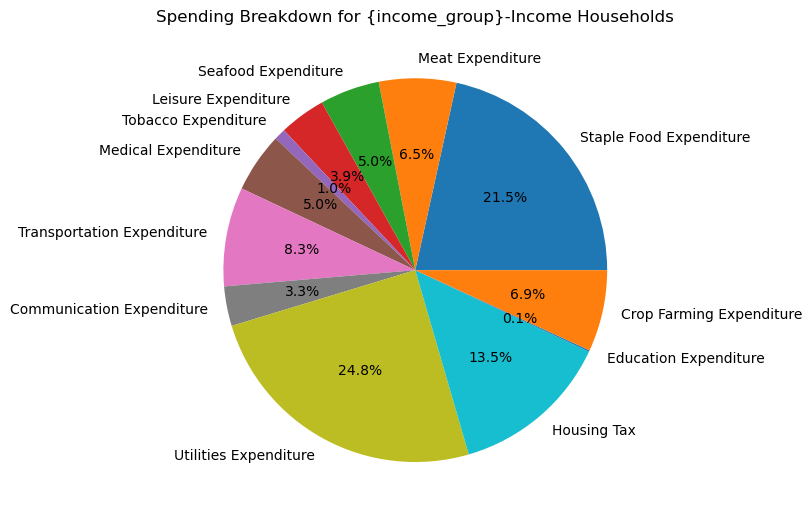

In [70]:
available_expenditure_columns = [col for col in expenditure_columns if col in df_cleaned.columns]

for income_group in ["Low", "Medium", "High"]:
    plt.figure(figsize=(8, 8))
    group_means = df_cleaned[df_cleaned["Income Level"] == income_group][available_expenditure_columns].mean()
    group_means.plot.pie(autopct="%1.1f%%")
    plt.title("Spending Breakdown for {income_group}-Income Households")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()


#### Model Comparison - Linear Regression vs. Random Forest

In [71]:
predictor_columns = ["Total Household Income", "Total Number of Family members", "Education Rank"]
X = df_cleaned[predictor_columns]
y = df_cleaned["Total Expenses"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
r2_linear = r2_score(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("Linear Regression R² Score:", r2_linear)
print("Linear Regression MSE:", mse_linear)
print("Random Forest R² Score:", r2_rf)
print("Random Forest MSE:", mse_rf)


Linear Regression R² Score: 0.5345972724197969
Linear Regression MSE: 2418510.0279588792
Random Forest R² Score: 0.5865521574433452
Random Forest MSE: 2148521.471844867


## Conclusion

In [72]:
if r2_rf > r2_linear:
    print("Conclusion: The Random Forest model performed better, suggesting non-linear relationships between income, family size, and expenditure.")
elif r2_linear > r2_rf:
    print("Conclusion: The Linear Regression model performed better, suggesting a stronger linear relationship between income and expenditure.")
else:
    print("Conclusion: Both models have similar performance, indicating that additional factors may influence spending behavior.")


Conclusion: The Random Forest model performed better, suggesting non-linear relationships between income, family size, and expenditure.
